##NER##

Named Entity Recognition

How training happens in NER:

https://nanonets.com/blog/named-entity-recognition-with-nltk-and-spacy/#:~:text=Named%20entity%20recognition%20(NER)%20is,person%2C%20location%2C%20organisation%20etc.

Custom training using Spacy NER: 

https://www.machinelearningplus.com/nlp/training-custom-ner-model-in-spacy/

https://towardsdatascience.com/train-ner-with-custom-training-data-using-spacy-525ce748fab7



Here we will be using Spacy NER to train on positive ,negative and neutral sentences with individual models. Here we will be training three models one for positive sentiment sentences other for negative sentiment sentences and another for neutral sentiment sentences. We are building it individually because the main purpose of NER is to detect the word or phrases that determine the sentiment of that sentence. If we feed in the model with neutral, negtive and positive sentences it may get confused with those contarary words. Unlike the previous model we are not feeding the sentiment of the sentence to the model nor we are labelling the as positive, negative or neutral.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
train_data=pd.read_csv('/content/drive/MyDrive/case_study_2_new/train_pos_neg_neu.csv')
test_data=pd.read_csv('/content/drive/MyDrive/case_study_2_new/test_pos_neg_neu.csv')
print(train_data.shape)
print(test_data.shape)

(21984, 7)
(5496, 7)


In [ ]:
!pip install -U spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import random
from pathlib import Path
import spacy
from tqdm import tqdm

In [ ]:
positive_data=train_data[train_data['sentiment']=='positive']
positive_data=positive_data.reset_index(drop=True)
negative_data=train_data[train_data['sentiment']=='negative']
negative_data=negative_data.reset_index(drop=True)
neutral_data=train_data[train_data['sentiment']=='neutral']
neutral_data=neutral_data.reset_index(drop=True)

In [ ]:
positive_data_test=test_data[test_data['sentiment']=='positive']
positive_data_test=positive_data_test.reset_index(drop=True)
negative_data_test=test_data[test_data['sentiment']=='negative']
negative_data_test=negative_data_test.reset_index(drop=True)
neutral_data_test=test_data[test_data['sentiment']=='neutral']
neutral_data_test=neutral_data_test.reset_index(drop=True)

Here our dataset preparation must be done as in the image below.
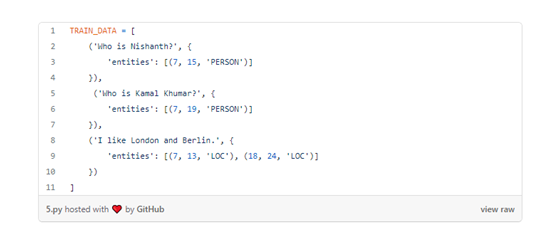

Reference: https://towardsdatascience.com/train-ner-with-custom-training-data-using-spacy-525ce748fab7

In this case out entity is the selected text which has been marked as ST.

####For positive text####

In [ ]:
train_ner_pos=[]
for i in range(len(positive_data)):
    start_index=positive_data.iloc[i]['text'].find(positive_data.iloc[i]['selected_text']) #start index represents the start position of the selected text in the actual text
    end_index=start_index+len(positive_data.iloc[i]['selected_text'])# end index represents the end position of the selected text in the actual text
    train_dt=(positive_data.iloc[i]['text'],              
              {'entities':[[start_index,end_index,'ST']]})  
    train_ner_pos.append(train_dt)

In [ ]:
test_ner_pos=[]
for i in range(len(positive_data_test)):
    start_index=positive_data_test.iloc[i]['text'].find(positive_data_test.iloc[i]['selected_text'])
    end_index=start_index+len(positive_data_test.iloc[i]['selected_text'])
    test_dt=(positive_data_test.iloc[i]['text'],              
              {'entities':[[start_index,end_index,'ST']]})  
    test_ner_pos.append(test_dt)

In [ ]:
print('Sample sentences:')
for i in range(5):
  print(train_ner_pos[i])

Sample sentences:
('my momma is comin 2night !  2morrow tennis day with p?nar yuppie !', {'entities': [[58, 64, 'ST']]})
(' Good luck tonight! have fun', {'entities': [[1, 28, 'ST']]})
(' good luck C have funn!', {'entities': [[1, 23, 'ST']]})
(' ok point taken.  I`ll tell my team to stop our cynical championing of standards. Active-X is far better anyway', {'entities': [[96, 104, 'ST']]})
('hoping i didn`t fail english. that would just be sad', {'entities': [[0, 52, 'ST']]})


In [ ]:
len(train_ner_pos)

6865

In [ ]:
model = None

In [ ]:
spacy.__version__

'3.4.2'

In [ ]:
if model is not None:
    nlp = spacy.load(model)  
    print("Loaded model '%s'" % model)
else:
    nlp = spacy.blank('en')  
    print("Created blank 'en' model")

#set up the pipeline

#NER model is what we need so if the model has NER then no issue else get NER into the pipeline.
if 'ner' not in nlp.pipe_names:
    ner = nlp.add_pipe('ner')
else:
    ner = nlp.get_pipe('ner')

Created blank 'en' model


Pipes in NER:

Pipes contains tasks like tagging, parsing ,named entity recognition and so on.

Example of tagging: 

    I ate an apple
    (I,PRP) (ate,VB) (an,DT) (apple,NN)

example of named entity recognition:

    John and Mathew went to New York.
    (John,NAME) and (Mathew,NAME) went to (New York,PLACE).

This is how each task is done in the pipe.


An example:

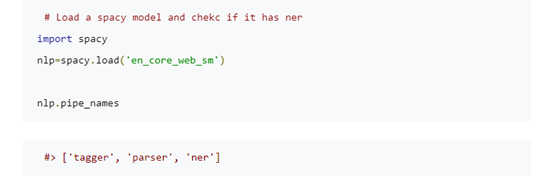

Here we can see that there are three tasks in the pipeline. The below image shows the output (truncated version) of all the tags that the model assigns it to the paragraph.

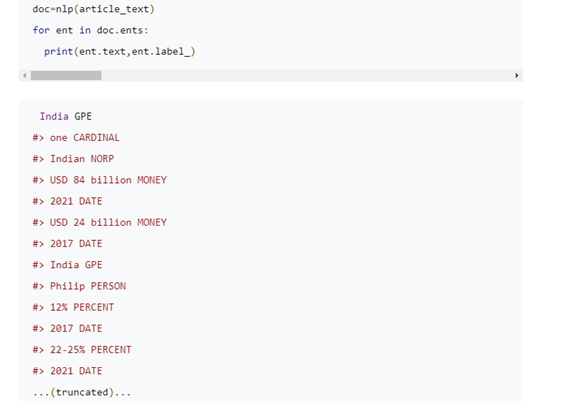

Here we can observe the model has tagged the grammer that is DT,VBD and so on and also the Name,Places,Money and so on.

Reference:

https://www.machinelearningplus.com/nlp/training-custom-ner-model-in-spacy/

In our task we will use only NER. NER is named Entity Recognition where the model learns to recognise things like person, money, places and things like that. Here our primary task is to detect the word or phrase that determine the sentiment of the text so NER model would be suitable. Here we will be training a blank NER model using custom training.

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from spacy.training.example import Example
from spacy.util import minibatch
for _, annotations in train_ner_pos:
    for ent in annotations.get('entities'):
        ner.add_label(ent[2])# Adding ST as the only label to the model

n_iter=100 #Number of iteration
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
with nlp.disable_pipes(*other_pipes):  # only train NER disabling other pipe
    optimizer = nlp.begin_training()
    example=[]
    for text, annotations in tqdm(train_ner_pos):
        doc = nlp.make_doc(text)
        example.append(Example.from_dict(doc, annotations))
    nlp.initialize(lambda: example)
    for i in tqdm(range(n_iter)):
        losses={}
        random.shuffle(example)
        for batch in minibatch(example, size=128):
            nlp.update(batch,drop=0.2,  #drop is the dropout rate of the model
                      losses=losses)
        print(losses)

  1%|          | 1/100 [00:17<29:24, 17.83s/it]

{'ner': 21845.705427069945}


  2%|▏         | 2/100 [00:35<29:23, 17.99s/it]

{'ner': 10142.083514523722}


  3%|▎         | 3/100 [00:53<28:43, 17.77s/it]

{'ner': 9248.616838135378}


  4%|▍         | 4/100 [01:12<29:02, 18.15s/it]

{'ner': 8763.390969161686}


  5%|▌         | 5/100 [01:30<28:53, 18.24s/it]

{'ner': 8468.499353435998}


  6%|▌         | 6/100 [01:47<27:58, 17.86s/it]

{'ner': 8239.30412520028}


  7%|▋         | 7/100 [02:04<27:14, 17.58s/it]

{'ner': 8033.300644371519}


  8%|▊         | 8/100 [02:21<26:42, 17.42s/it]

{'ner': 7884.320544153253}


  9%|▉         | 9/100 [02:39<26:36, 17.54s/it]

{'ner': 7636.045235982103}


 10%|█         | 10/100 [02:56<26:13, 17.48s/it]

{'ner': 7398.61002631958}


 11%|█         | 11/100 [03:14<26:01, 17.55s/it]

{'ner': 7302.255474286074}


 12%|█▏        | 12/100 [03:32<25:46, 17.58s/it]

{'ner': 7125.7275999103}


 13%|█▎        | 13/100 [03:49<25:24, 17.52s/it]

{'ner': 6920.137030293168}


 14%|█▍        | 14/100 [04:06<24:50, 17.34s/it]

{'ner': 6788.029835343795}


 15%|█▌        | 15/100 [04:23<24:19, 17.17s/it]

{'ner': 6594.342558049305}


 16%|█▌        | 16/100 [04:40<23:57, 17.11s/it]

{'ner': 6495.845222806671}


 17%|█▋        | 17/100 [04:58<24:08, 17.46s/it]

{'ner': 6375.417222056595}


 18%|█▊        | 18/100 [05:15<23:40, 17.32s/it]

{'ner': 6126.734794840547}


 19%|█▉        | 19/100 [05:33<23:32, 17.44s/it]

{'ner': 6194.829689427523}


 20%|██        | 20/100 [05:51<23:32, 17.66s/it]

{'ner': 5910.057084476581}


 21%|██        | 21/100 [06:09<23:23, 17.77s/it]

{'ner': 5773.362336138958}


 22%|██▏       | 22/100 [06:28<23:28, 18.05s/it]

{'ner': 5659.363805493512}


 23%|██▎       | 23/100 [06:46<23:06, 18.00s/it]

{'ner': 5489.462793072413}


 24%|██▍       | 24/100 [07:03<22:40, 17.91s/it]

{'ner': 5408.840261387182}


 25%|██▌       | 25/100 [07:21<22:12, 17.77s/it]

{'ner': 5418.472030228825}


 26%|██▌       | 26/100 [07:39<22:15, 18.05s/it]

{'ner': 5237.33013845047}


 27%|██▋       | 27/100 [07:58<22:11, 18.25s/it]

{'ner': 5175.810819552323}


 28%|██▊       | 28/100 [08:17<22:06, 18.42s/it]

{'ner': 5002.9467848802815}


 29%|██▉       | 29/100 [08:36<22:10, 18.73s/it]

{'ner': 4996.391015173896}


 30%|███       | 30/100 [08:54<21:27, 18.39s/it]

{'ner': 4831.862834950621}


 31%|███       | 31/100 [09:11<20:41, 17.99s/it]

{'ner': 4799.316989877328}


 32%|███▏      | 32/100 [09:28<19:56, 17.59s/it]

{'ner': 4724.580642800944}


 33%|███▎      | 33/100 [09:44<19:21, 17.34s/it]

{'ner': 4553.107323887556}


 34%|███▍      | 34/100 [10:01<18:52, 17.16s/it]

{'ner': 4473.940513138601}


 35%|███▌      | 35/100 [10:18<18:23, 16.98s/it]

{'ner': 4357.030877836879}


 36%|███▌      | 36/100 [10:35<18:07, 16.99s/it]

{'ner': 4413.902987186934}


 37%|███▋      | 37/100 [10:51<17:41, 16.84s/it]

{'ner': 4345.889999071287}


 38%|███▊      | 38/100 [11:08<17:20, 16.79s/it]

{'ner': 4159.000259862956}


 39%|███▉      | 39/100 [11:25<17:01, 16.74s/it]

{'ner': 4093.0096785251963}


 40%|████      | 40/100 [11:42<16:52, 16.87s/it]

{'ner': 4116.3480341404465}


 41%|████      | 41/100 [12:00<16:55, 17.21s/it]

{'ner': 4064.1127678363}


 42%|████▏     | 42/100 [12:16<16:26, 17.01s/it]

{'ner': 3896.0973469144424}


 43%|████▎     | 43/100 [12:33<16:06, 16.95s/it]

{'ner': 3927.5185599780443}


 44%|████▍     | 44/100 [12:50<15:44, 16.86s/it]

{'ner': 3812.7441009295476}


 45%|████▌     | 45/100 [13:07<15:27, 16.87s/it]

{'ner': 3801.875706262776}


 46%|████▌     | 46/100 [13:23<15:05, 16.76s/it]

{'ner': 3676.6256114921257}


 47%|████▋     | 47/100 [13:40<14:56, 16.91s/it]

{'ner': 3632.36456593868}


 48%|████▊     | 48/100 [13:57<14:34, 16.81s/it]

{'ner': 3547.8175354071077}


 49%|████▉     | 49/100 [14:14<14:20, 16.87s/it]

{'ner': 3554.5304609950836}


 50%|█████     | 50/100 [14:30<13:56, 16.73s/it]

{'ner': 3468.4310086709584}


 51%|█████     | 51/100 [14:47<13:37, 16.68s/it]

{'ner': 3408.207435671485}


 52%|█████▏    | 52/100 [15:03<13:13, 16.53s/it]

{'ner': 3403.6330371963977}


 53%|█████▎    | 53/100 [15:21<13:10, 16.82s/it]

{'ner': 3265.257438719271}


 54%|█████▍    | 54/100 [15:38<13:06, 17.11s/it]

{'ner': 3295.7187586697}


 55%|█████▌    | 55/100 [15:55<12:43, 16.97s/it]

{'ner': 3283.772783453035}


 56%|█████▌    | 56/100 [16:12<12:21, 16.86s/it]

{'ner': 3178.504960780059}


 57%|█████▋    | 57/100 [16:29<12:04, 16.85s/it]

{'ner': 3170.7807576989685}


 58%|█████▊    | 58/100 [16:46<11:52, 16.97s/it]

{'ner': 3153.205382121119}


 59%|█████▉    | 59/100 [17:02<11:29, 16.82s/it]

{'ner': 2959.3680019700187}


 60%|██████    | 60/100 [17:19<11:07, 16.70s/it]

{'ner': 2958.431489139127}


 61%|██████    | 61/100 [17:35<10:52, 16.73s/it]

{'ner': 3006.6610724512934}


 62%|██████▏   | 62/100 [17:52<10:36, 16.75s/it]

{'ner': 2912.1242099067877}


 63%|██████▎   | 63/100 [18:09<10:19, 16.74s/it]

{'ner': 2828.1818116490904}


 64%|██████▍   | 64/100 [18:26<10:02, 16.75s/it]

{'ner': 2943.5240318404853}


 65%|██████▌   | 65/100 [18:43<09:50, 16.86s/it]

{'ner': 2832.849404622217}


 66%|██████▌   | 66/100 [19:01<09:46, 17.26s/it]

{'ner': 2796.400585859292}


 67%|██████▋   | 67/100 [19:18<09:27, 17.21s/it]

{'ner': 2687.452547046007}


 68%|██████▊   | 68/100 [19:35<09:08, 17.14s/it]

{'ner': 2729.6133982449614}


 69%|██████▉   | 69/100 [19:52<08:46, 16.97s/it]

{'ner': 2648.5343329371867}


 70%|███████   | 70/100 [20:08<08:25, 16.85s/it]

{'ner': 2639.221078196089}


 71%|███████   | 71/100 [20:25<08:09, 16.89s/it]

{'ner': 2637.6413404395325}


 72%|███████▏  | 72/100 [20:42<07:52, 16.88s/it]

{'ner': 2579.440767048134}


 73%|███████▎  | 73/100 [20:59<07:32, 16.78s/it]

{'ner': 2583.8891974996054}


 74%|███████▍  | 74/100 [21:15<07:15, 16.75s/it]

{'ner': 2557.988581934043}


 75%|███████▌  | 75/100 [21:32<06:57, 16.71s/it]

{'ner': 2528.0046369908428}


 76%|███████▌  | 76/100 [21:49<06:44, 16.87s/it]

{'ner': 2404.2002612882775}


 77%|███████▋  | 77/100 [22:06<06:26, 16.79s/it]

{'ner': 2517.1288119252918}


 78%|███████▊  | 78/100 [22:23<06:14, 17.01s/it]

{'ner': 2508.724143002335}


 79%|███████▉  | 79/100 [22:41<06:00, 17.17s/it]

{'ner': 2448.1488623823716}


 80%|████████  | 80/100 [22:58<05:43, 17.18s/it]

{'ner': 2337.9975747959884}


 81%|████████  | 81/100 [23:15<05:24, 17.07s/it]

{'ner': 2262.101397621144}


 82%|████████▏ | 82/100 [23:32<05:05, 16.97s/it]

{'ner': 2258.029918912017}


 83%|████████▎ | 83/100 [23:49<04:48, 16.95s/it]

{'ner': 2322.9929472416334}


 84%|████████▍ | 84/100 [24:05<04:31, 16.94s/it]

{'ner': 2272.382304715206}


 85%|████████▌ | 85/100 [24:22<04:13, 16.90s/it]

{'ner': 2253.156579567906}


 86%|████████▌ | 86/100 [24:39<03:56, 16.89s/it]

{'ner': 2150.2923291538036}


 87%|████████▋ | 87/100 [24:56<03:38, 16.80s/it]

{'ner': 2096.193837055248}


 88%|████████▊ | 88/100 [25:12<03:20, 16.71s/it]

{'ner': 2151.729316162423}


 89%|████████▉ | 89/100 [25:29<03:05, 16.87s/it]

{'ner': 2156.2043921283507}


 90%|█████████ | 90/100 [25:47<02:50, 17.06s/it]

{'ner': 2185.394702272191}


 91%|█████████ | 91/100 [26:06<02:37, 17.51s/it]

{'ner': 2085.304639621736}


 92%|█████████▏| 92/100 [26:22<02:18, 17.27s/it]

{'ner': 1998.1898989577737}


 93%|█████████▎| 93/100 [26:39<02:00, 17.24s/it]

{'ner': 1997.4797571181255}


 94%|█████████▍| 94/100 [26:56<01:42, 17.09s/it]

{'ner': 2113.076002073332}


 95%|█████████▌| 95/100 [27:13<01:24, 16.94s/it]

{'ner': 2076.308027548403}


 96%|█████████▌| 96/100 [27:29<01:07, 16.79s/it]

{'ner': 2007.6960521512842}


 97%|█████████▋| 97/100 [27:46<00:50, 16.82s/it]

{'ner': 2003.8610466328896}


 98%|█████████▊| 98/100 [28:03<00:33, 16.85s/it]

{'ner': 1919.7562465631208}


 99%|█████████▉| 99/100 [28:20<00:16, 16.82s/it]

{'ner': 2032.0930074439484}


100%|██████████| 100/100 [28:36<00:00, 17.17s/it]

{'ner': 1906.6598527637757}


In [ ]:
print('Sample of how the data will be tokenised in case of NER:')
for i in range(5):
  print(i+1)
  print('Overall:',example[i])
  print('**********'*10)

Sample of how the data will be tokenised in case of NER:
1
Overall: {'doc_annotation': {'cats': {}, 'entities': ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ST', 'I-ST', 'I-ST', 'I-ST', 'L-ST', 'O', 'O', 'O', 'O', 'O'], 'spans': {}, 'links': {}}, 'token_annotation': {'ORTH': [' ', '-', 'Wow', ',', 'I', 'didn`t', 'realise', 'you', 'were', 'Hami', '.', 'lol', '.', 'Thanks', 'for', 'all', 'the', 'comments', 'on', 'my', 'blog', ',', 'dude'], 'SPACY': [False, True, False, True, True, True, True, True, True, False, True, False, True, True, True, True, True, True, True, True, False, True, False], 'TAG': ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''], 'LEMMA': ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''], 'POS': ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''], 'MORPH': ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 

As the library is updated many of the previous exsiting fuction was changed. Below documentation was helpful for defining the custom training using spacy.

Reference:

https://spacy.io/usage/v3#incompat:~:text=dictionary%20of%20annotations.-,TRAINING%20LOOP,-TRAIN_DATA%20%3D%20%5B

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
output_dir='/content/drive/MyDrive/case_study_2_new/ner_model/positive_model_rev_new'
if output_dir is not None:
    output_dir = Path(output_dir)
    if not output_dir.exists():
        output_dir.mkdir()
    nlp.to_disk(output_dir)
    print("Saved model to", output_dir)

Saved model to /content/drive/MyDrive/case_study_2_new/ner_model/positive_model_rev_new


In [ ]:
nlp_1=spacy.load('/content/drive/MyDrive/case_study_2_new/ner_model/positive_model_rev_new')

####For negative####

In [ ]:
train_ner_neg=[]
for i in range(len(negative_data)):
    start_index=negative_data.iloc[i]['text'].find(negative_data.iloc[i]['selected_text'])
    end_index=start_index+len(negative_data.iloc[i]['selected_text'])
    train_dt=(negative_data.iloc[i]['text'],              
              {'entities':[[start_index,end_index,'ST']]})  
    train_ner_neg.append(train_dt)

test_ner_neg=[]
for i in range(len(negative_data_test)):
    start_index=negative_data_test.iloc[i]['text'].find(negative_data_test.iloc[i]['selected_text'])
    end_index=start_index+len(negative_data_test.iloc[i]['selected_text'])
    test_dt=(negative_data_test.iloc[i]['text'],              
              {'entities':[[start_index,end_index,'ST']]})  
    test_ner_neg.append(test_dt)

In [ ]:
print('Sample data:')
for i in range(5):
  print(train_ner_neg[i])

Sample data:
('ah remember the days when you`d sleep in until noon? well guess who did that today? god i feel like a loser', {'entities': [[102, 107, 'ST']]})
('  We don`t feel too comfortable using it. It`s not awful, but pretty icky.  Scurrying to find a deal...', {'entities': [[40, 73, 'ST']]})
('everyone vote for  for the mtv movie awards coz my comp is mashed up and wont let me vote!  i will somehow!!!!!!', {'entities': [[59, 68, 'ST']]})
(' SAME. its just not happening, and im going out too!. UH-OH.', {'entities': [[11, 30, 'ST']]})
('It is so annoying when she starts typing on her computer in the middle of the night!', {'entities': [[9, 17, 'ST']]})


In [ ]:
model = None
if model is not None:
    nlp_neg = spacy.load(model)  
    print("Loaded model '%s'" % model)
else:
    nlp_neg = spacy.blank('en')  
    print("Created blank 'en' model")

#set up the pipeline

if 'ner' not in nlp_neg.pipe_names:
    ner = nlp_neg.add_pipe('ner')
else:
    ner = nlp_neg.get_pipe('ner')

Created blank 'en' model


In [ ]:
import warnings
warnings.filterwarnings('ignore')
from spacy.training.example import Example
from spacy.util import minibatch
for _, annotations in train_ner_neg:
    for ent in annotations.get('entities'):
        ner.add_label(ent[2])

n_iter=100
other_pipes = [pipe for pipe in nlp_neg.pipe_names if pipe != 'ner']
with nlp_neg.disable_pipes(*other_pipes):  # only train NER
    optimizer = nlp_neg.begin_training()
    example=[]
    for text, annotations in tqdm(train_ner_neg):
        doc = nlp_neg.make_doc(text)
        example.append(Example.from_dict(doc, annotations))
    nlp_neg.initialize(lambda: example)
    for i in tqdm(range(n_iter)):
        losses={}
        random.shuffle(example)
        for batch in minibatch(example, size=128):
            nlp_neg.update(batch,drop=0.2,  
                      losses=losses)
        print(losses)

  1%|          | 1/100 [00:15<25:46, 15.62s/it]

{'ner': 21869.79547660006}


  2%|▏         | 2/100 [00:33<27:17, 16.71s/it]

{'ner': 10095.784057349307}


  3%|▎         | 3/100 [00:48<26:09, 16.18s/it]

{'ner': 9023.606405206421}


  4%|▍         | 4/100 [01:04<25:28, 15.93s/it]

{'ner': 8461.203977367753}


  5%|▌         | 5/100 [01:19<24:54, 15.74s/it]

{'ner': 8172.061028290289}


  6%|▌         | 6/100 [01:35<24:38, 15.73s/it]

{'ner': 7945.305305096994}


  7%|▋         | 7/100 [01:50<24:15, 15.65s/it]

{'ner': 7784.204316521917}


  8%|▊         | 8/100 [02:06<24:02, 15.68s/it]

{'ner': 7545.245957795933}


  9%|▉         | 9/100 [02:22<23:42, 15.63s/it]

{'ner': 7374.961272874293}


 10%|█         | 10/100 [02:38<23:37, 15.75s/it]

{'ner': 7205.587797173009}


 11%|█         | 11/100 [02:55<24:17, 16.37s/it]

{'ner': 7054.537019465835}


 12%|█▏        | 12/100 [03:13<24:22, 16.61s/it]

{'ner': 6797.399293389366}


 13%|█▎        | 13/100 [03:30<24:33, 16.94s/it]

{'ner': 6711.042839135418}


 14%|█▍        | 14/100 [03:48<24:33, 17.13s/it]

{'ner': 6492.15965360203}


 15%|█▌        | 15/100 [04:05<24:28, 17.28s/it]

{'ner': 6335.237439871144}


 16%|█▌        | 16/100 [04:22<23:54, 17.08s/it]

{'ner': 6275.667530562289}


 17%|█▋        | 17/100 [04:41<24:23, 17.64s/it]

{'ner': 6060.3277682452845}


 18%|█▊        | 18/100 [05:00<24:38, 18.02s/it]

{'ner': 5859.74271790318}


 19%|█▉        | 19/100 [05:20<25:09, 18.64s/it]

{'ner': 5710.937301048749}


 20%|██        | 20/100 [05:39<25:05, 18.82s/it]

{'ner': 5683.171084643929}


 21%|██        | 21/100 [05:58<24:38, 18.71s/it]

{'ner': 5580.032445502155}


 22%|██▏       | 22/100 [06:17<24:23, 18.76s/it]

{'ner': 5335.919100421727}


 23%|██▎       | 23/100 [06:37<24:55, 19.42s/it]

{'ner': 5290.000881529184}


 24%|██▍       | 24/100 [06:57<24:32, 19.38s/it]

{'ner': 5167.36757169958}


 25%|██▌       | 25/100 [07:15<23:49, 19.06s/it]

{'ner': 5038.781813380684}


 26%|██▌       | 26/100 [07:33<23:05, 18.72s/it]

{'ner': 4999.645763569434}


 27%|██▋       | 27/100 [07:49<21:55, 18.02s/it]

{'ner': 4780.183950950817}


 28%|██▊       | 28/100 [08:06<21:07, 17.60s/it]

{'ner': 4818.799800917473}


 29%|██▉       | 29/100 [08:22<20:23, 17.23s/it]

{'ner': 4632.914646228562}


 30%|███       | 30/100 [08:39<19:48, 16.98s/it]

{'ner': 4516.395301487927}


 31%|███       | 31/100 [08:55<19:14, 16.73s/it]

{'ner': 4386.450435620206}


 32%|███▏      | 32/100 [09:12<18:58, 16.75s/it]

{'ner': 4380.496251935321}


 33%|███▎      | 33/100 [09:29<18:49, 16.86s/it]

{'ner': 4181.121142678985}


 34%|███▍      | 34/100 [09:46<18:29, 16.81s/it]

{'ner': 4254.042523381158}


 35%|███▌      | 35/100 [10:04<18:36, 17.17s/it]

{'ner': 4101.262577342928}


 36%|███▌      | 36/100 [10:20<17:56, 16.83s/it]

{'ner': 4059.0670434710682}


 37%|███▋      | 37/100 [10:36<17:34, 16.73s/it]

{'ner': 3965.982366298762}


 38%|███▊      | 38/100 [10:52<17:10, 16.62s/it]

{'ner': 3838.7262611308292}


 39%|███▉      | 39/100 [11:09<16:47, 16.51s/it]

{'ner': 3822.8556346724718}


 40%|████      | 40/100 [11:25<16:22, 16.37s/it]

{'ner': 3698.9904657212714}


 41%|████      | 41/100 [11:41<16:01, 16.30s/it]

{'ner': 3703.959883670631}


 42%|████▏     | 42/100 [11:57<15:42, 16.25s/it]

{'ner': 3662.5623337930665}


 43%|████▎     | 43/100 [12:13<15:26, 16.26s/it]

{'ner': 3501.58268726489}


 44%|████▍     | 44/100 [12:30<15:10, 16.25s/it]

{'ner': 3530.7684455866747}


 45%|████▌     | 45/100 [12:46<14:57, 16.32s/it]

{'ner': 3397.9012338941857}


 46%|████▌     | 46/100 [13:02<14:38, 16.27s/it]

{'ner': 3339.029720069233}


 47%|████▋     | 47/100 [13:18<14:19, 16.22s/it]

{'ner': 3267.2256675814956}


 48%|████▊     | 48/100 [13:36<14:31, 16.76s/it]

{'ner': 3182.2198190878967}


 49%|████▉     | 49/100 [13:53<14:07, 16.62s/it]

{'ner': 3138.0403892050417}


 50%|█████     | 50/100 [14:10<13:57, 16.76s/it]

{'ner': 3204.458767186289}


 51%|█████     | 51/100 [14:26<13:39, 16.72s/it]

{'ner': 3010.1627741527177}


 52%|█████▏    | 52/100 [14:42<13:13, 16.53s/it]

{'ner': 3042.4042806585103}


 53%|█████▎    | 53/100 [14:59<12:54, 16.49s/it]

{'ner': 2967.4943622170304}


 54%|█████▍    | 54/100 [15:15<12:30, 16.31s/it]

{'ner': 2885.0816615352614}


 55%|█████▌    | 55/100 [15:31<12:09, 16.22s/it]

{'ner': 2877.862588390659}


 56%|█████▌    | 56/100 [15:47<11:49, 16.14s/it]

{'ner': 2761.1058722572056}


 57%|█████▋    | 57/100 [16:03<11:41, 16.32s/it]

{'ner': 2801.7863697692114}


 58%|█████▊    | 58/100 [16:19<11:22, 16.25s/it]

{'ner': 2833.9641898163222}


 59%|█████▉    | 59/100 [16:36<11:06, 16.24s/it]

{'ner': 2691.1416370929046}


 60%|██████    | 60/100 [16:52<10:45, 16.13s/it]

{'ner': 2713.188705857823}


 61%|██████    | 61/100 [17:11<11:02, 16.99s/it]

{'ner': 2577.4556291937597}


 62%|██████▏   | 62/100 [17:29<10:58, 17.33s/it]

{'ner': 2494.2796344045514}


 63%|██████▎   | 63/100 [17:46<10:43, 17.40s/it]

{'ner': 2473.6649574913977}


 64%|██████▍   | 64/100 [18:03<10:23, 17.31s/it]

{'ner': 2481.4045945148005}


 65%|██████▌   | 65/100 [18:19<09:53, 16.95s/it]

{'ner': 2400.867391027567}


 66%|██████▌   | 66/100 [18:36<09:32, 16.85s/it]

{'ner': 2454.4350803764855}


 67%|██████▋   | 67/100 [18:52<09:06, 16.55s/it]

{'ner': 2446.960066438877}


 68%|██████▊   | 68/100 [19:08<08:48, 16.53s/it]

{'ner': 2370.7036325232643}


 69%|██████▉   | 69/100 [19:26<08:38, 16.72s/it]

{'ner': 2273.283984287391}


 70%|███████   | 70/100 [19:43<08:30, 17.02s/it]

{'ner': 2279.3197316869346}


 71%|███████   | 71/100 [20:01<08:16, 17.14s/it]

{'ner': 2314.730306599568}


 72%|███████▏  | 72/100 [20:17<07:53, 16.92s/it]

{'ner': 2192.7055282702195}


 73%|███████▎  | 73/100 [20:35<07:47, 17.32s/it]

{'ner': 2135.2256719406464}


 74%|███████▍  | 74/100 [20:51<07:20, 16.96s/it]

{'ner': 2232.90040673649}


 75%|███████▌  | 75/100 [21:08<07:00, 16.81s/it]

{'ner': 2122.35346084472}


 76%|███████▌  | 76/100 [21:24<06:35, 16.48s/it]

{'ner': 2168.650309554888}


 77%|███████▋  | 77/100 [21:40<06:16, 16.38s/it]

{'ner': 2162.138184017812}


 78%|███████▊  | 78/100 [21:55<05:55, 16.15s/it]

{'ner': 2021.4856203337354}


 79%|███████▉  | 79/100 [22:11<05:36, 16.02s/it]

{'ner': 2057.128198325403}


 80%|████████  | 80/100 [22:27<05:17, 15.88s/it]

{'ner': 1924.7195563056364}


 81%|████████  | 81/100 [22:43<05:03, 15.96s/it]

{'ner': 2063.12800544545}


 82%|████████▏ | 82/100 [22:58<04:45, 15.86s/it]

{'ner': 1982.5031562160004}


 83%|████████▎ | 83/100 [23:14<04:30, 15.89s/it]

{'ner': 1900.3900611713523}


 84%|████████▍ | 84/100 [23:31<04:17, 16.09s/it]

{'ner': 1852.50872010021}


 85%|████████▌ | 85/100 [23:48<04:05, 16.37s/it]

{'ner': 1915.003724283764}


 86%|████████▌ | 86/100 [24:05<03:52, 16.58s/it]

{'ner': 1928.8566673990456}


 87%|████████▋ | 87/100 [24:21<03:34, 16.50s/it]

{'ner': 1830.7507238859712}


 88%|████████▊ | 88/100 [24:37<03:16, 16.36s/it]

{'ner': 1799.061135690831}


 89%|████████▉ | 89/100 [24:55<03:04, 16.76s/it]

{'ner': 1704.9020712335036}


 90%|█████████ | 90/100 [25:14<02:54, 17.43s/it]

{'ner': 1754.3770670793258}


 91%|█████████ | 91/100 [25:33<02:41, 17.89s/it]

{'ner': 1808.0215677114738}


 92%|█████████▏| 92/100 [25:52<02:24, 18.12s/it]

{'ner': 1708.316405251117}


 93%|█████████▎| 93/100 [26:11<02:09, 18.48s/it]

{'ner': 1664.4395507273719}


 94%|█████████▍| 94/100 [26:30<01:51, 18.60s/it]

{'ner': 1845.9692865846016}


 95%|█████████▌| 95/100 [26:50<01:35, 19.08s/it]

{'ner': 1706.8385138299054}


 96%|█████████▌| 96/100 [27:08<01:14, 18.65s/it]

{'ner': 1643.5826812237726}


 97%|█████████▋| 97/100 [27:25<00:54, 18.23s/it]

{'ner': 1675.974234394793}


 98%|█████████▊| 98/100 [27:43<00:36, 18.30s/it]

{'ner': 1647.083512233179}


 99%|█████████▉| 99/100 [28:00<00:17, 17.90s/it]

{'ner': 1644.4588730113019}


100%|██████████| 100/100 [28:17<00:00, 16.97s/it]

{'ner': 1603.670458810325}


In [ ]:
output_dir='/content/drive/MyDrive/case_study_2_new/ner_model/negative_model_rev_new'
if output_dir is not None:
    output_dir = Path(output_dir)
    if not output_dir.exists():
        output_dir.mkdir()
    nlp_neg.to_disk(output_dir)
    print("Saved model to", output_dir)

Saved model to /content/drive/MyDrive/case_study_2_new/ner_model/negative_model_rev_new


####For neutral####

In [ ]:
train_ner_neut=[]
for i in range(len(neutral_data)):
    start_index=neutral_data.iloc[i]['text'].find(neutral_data.iloc[i]['selected_text'])
    end_index=start_index+len(neutral_data.iloc[i]['selected_text'])
    train_dt=(neutral_data.iloc[i]['text'],              
              {'entities':[[start_index,end_index,'ST']]})  
    train_ner_neut.append(train_dt)

test_ner_neut=[]
for i in range(len(neutral_data_test)):
    start_index=neutral_data_test.iloc[i]['text'].find(neutral_data_test.iloc[i]['selected_text'])
    end_index=start_index+len(neutral_data_test.iloc[i]['selected_text'])
    test_dt=(neutral_data_test.iloc[i]['text'],              
              {'entities':[[start_index,end_index,'ST']]})  
    test_ner_neut.append(test_dt)

In [ ]:
print('Sample data:')
for i in range(5):
  print(train_ner_neut[i])

Sample data:
(' Press `Ctrl` on bottom right. It`s there.  KY', {'entities': [[1, 46, 'ST']]})
(' I do that all the time', {'entities': [[1, 23, 'ST']]})
('getttin ready.', {'entities': [[0, 14, 'ST']]})
('working until10', {'entities': [[0, 15, 'ST']]})
(' Happy Birthday Mel. We miss you in the UK', {'entities': [[1, 42, 'ST']]})


In [ ]:
model = None
if model is not None:
    nlp_neut = spacy.load(model)  
    print("Loaded model '%s'" % model)
else:
    nlp_neut = spacy.blank('en')  
    print("Created blank 'en' model")

#set up the pipeline

if 'ner' not in nlp_neut.pipe_names:
    ner = nlp_neut.add_pipe('ner')
else:
    ner = nlp_neut.get_pipe('ner')

Created blank 'en' model


In [ ]:
import warnings
warnings.filterwarnings('ignore')
from spacy.training.example import Example
from spacy.util import minibatch
for _, annotations in train_ner_neut:
    for ent in annotations.get('entities'):
        ner.add_label(ent[2])

n_iter=100
other_pipes = [pipe for pipe in nlp_neut.pipe_names if pipe != 'ner']
with nlp_neut.disable_pipes(*other_pipes):  # only train NER
    optimizer = nlp_neut.begin_training()
    example=[]
    for text, annotations in tqdm(train_ner_neut):
        doc = nlp_neut.make_doc(text)
        example.append(Example.from_dict(doc, annotations))
    nlp_neut.initialize(lambda: example)
    for i in tqdm(range(n_iter)):
        losses={}
        random.shuffle(example)
        for batch in minibatch(example, size=128):
            nlp_neut.update(batch,drop=0.2,  
                      losses=losses)
        print(losses)

  1%|          | 1/100 [00:21<35:30, 21.52s/it]

{'ner': 19236.941743615633}


  2%|▏         | 2/100 [00:46<38:47, 23.75s/it]

{'ner': 2121.9747692270084}


  3%|▎         | 3/100 [01:08<36:57, 22.86s/it]

{'ner': 1942.1589478169858}


  4%|▍         | 4/100 [01:30<35:41, 22.31s/it]

{'ner': 1698.7808745033087}


  5%|▌         | 5/100 [01:54<36:37, 23.13s/it]

{'ner': 1467.354088125585}


  6%|▌         | 6/100 [02:19<36:53, 23.55s/it]

{'ner': 1337.2704847799957}


  7%|▋         | 7/100 [02:41<36:07, 23.31s/it]

{'ner': 1160.7187311495395}


  8%|▊         | 8/100 [03:07<36:45, 23.97s/it]

{'ner': 1094.1527351091604}


  9%|▉         | 9/100 [03:30<36:06, 23.81s/it]

{'ner': 1027.9438767218676}


 10%|█         | 10/100 [03:52<34:33, 23.04s/it]

{'ner': 928.8017766627911}


 11%|█         | 11/100 [04:13<33:15, 22.42s/it]

{'ner': 863.0804719818333}


 12%|█▏        | 12/100 [04:34<32:14, 21.98s/it]

{'ner': 820.2747223885248}


 13%|█▎        | 13/100 [04:55<31:49, 21.95s/it]

{'ner': 763.4412665265605}


 14%|█▍        | 14/100 [05:17<31:28, 21.96s/it]

{'ner': 730.5579006710328}


 15%|█▌        | 15/100 [05:39<30:48, 21.74s/it]

{'ner': 674.6403402359167}


 16%|█▌        | 16/100 [06:00<30:11, 21.57s/it]

{'ner': 592.6365276179044}


 17%|█▋        | 17/100 [06:21<29:41, 21.46s/it]

{'ner': 611.3631997748168}


 18%|█▊        | 18/100 [06:43<29:37, 21.67s/it]

{'ner': 536.8282336757578}


 19%|█▉        | 19/100 [07:06<29:38, 21.95s/it]

{'ner': 538.0539392786808}


 20%|██        | 20/100 [07:27<29:02, 21.78s/it]

{'ner': 502.52148261994165}


 21%|██        | 21/100 [07:49<28:47, 21.87s/it]

{'ner': 484.3024714912458}


 22%|██▏       | 22/100 [08:10<28:11, 21.69s/it]

{'ner': 455.5336896142729}


 23%|██▎       | 23/100 [08:32<27:45, 21.63s/it]

{'ner': 436.5271078732284}


 24%|██▍       | 24/100 [08:53<27:14, 21.51s/it]

{'ner': 415.12183272723706}


 25%|██▌       | 25/100 [09:14<26:45, 21.41s/it]

{'ner': 387.8633758225806}


 26%|██▌       | 26/100 [09:36<26:19, 21.35s/it]

{'ner': 393.5312987488997}


 27%|██▋       | 27/100 [09:57<26:04, 21.43s/it]

{'ner': 367.1624359945897}


 28%|██▊       | 28/100 [10:20<26:11, 21.83s/it]

{'ner': 343.8323840891271}


 29%|██▉       | 29/100 [10:41<25:36, 21.64s/it]

{'ner': 306.21247445158207}


 30%|███       | 30/100 [11:02<25:05, 21.51s/it]

{'ner': 370.4835745381221}


 31%|███       | 31/100 [11:24<24:37, 21.41s/it]

{'ner': 334.68848717948447}


 32%|███▏      | 32/100 [11:45<24:19, 21.47s/it]

{'ner': 324.26609294623927}


 33%|███▎      | 33/100 [12:06<23:52, 21.38s/it]

{'ner': 299.5894220690954}


 34%|███▍      | 34/100 [12:28<23:29, 21.36s/it]

{'ner': 311.8529244712174}


 35%|███▌      | 35/100 [12:49<23:10, 21.39s/it]

{'ner': 265.24194198907213}


 36%|███▌      | 36/100 [13:11<23:06, 21.66s/it]

{'ner': 297.55463482342833}


 37%|███▋      | 37/100 [13:35<23:14, 22.14s/it]

{'ner': 252.37937786268736}


 38%|███▊      | 38/100 [14:00<23:55, 23.16s/it]

{'ner': 284.5969078998097}


 39%|███▉      | 39/100 [14:25<23:55, 23.53s/it]

{'ner': 260.7100838814683}


 40%|████      | 40/100 [14:48<23:28, 23.47s/it]

{'ner': 251.2433369439099}


 41%|████      | 41/100 [15:11<22:52, 23.27s/it]

{'ner': 252.31922624891712}


 42%|████▏     | 42/100 [15:32<22:01, 22.79s/it]

{'ner': 264.80195539588516}


 43%|████▎     | 43/100 [15:53<21:09, 22.28s/it]

{'ner': 206.44842941536155}


 44%|████▍     | 44/100 [16:15<20:30, 21.98s/it]

{'ner': 224.52176720924876}


 45%|████▌     | 45/100 [16:36<19:53, 21.70s/it]

{'ner': 220.624756985761}


 46%|████▌     | 46/100 [16:57<19:26, 21.60s/it]

{'ner': 209.90540659004571}


 47%|████▋     | 47/100 [17:19<19:10, 21.71s/it]

{'ner': 230.5122495891006}


 48%|████▊     | 48/100 [17:41<18:47, 21.69s/it]

{'ner': 205.62792970113597}


 49%|████▉     | 49/100 [18:02<18:14, 21.45s/it]

{'ner': 196.22096142993007}


 50%|█████     | 50/100 [18:23<17:46, 21.33s/it]

{'ner': 183.93199150081225}


 51%|█████     | 51/100 [18:44<17:25, 21.34s/it]

{'ner': 187.8210771642424}


 52%|█████▏    | 52/100 [19:05<16:57, 21.20s/it]

{'ner': 156.84474226978227}


 53%|█████▎    | 53/100 [19:26<16:32, 21.11s/it]

{'ner': 182.88957077149678}


 54%|█████▍    | 54/100 [19:47<16:09, 21.07s/it]

{'ner': 198.39628006850776}


 55%|█████▌    | 55/100 [20:08<15:48, 21.08s/it]

{'ner': 217.2473729213787}


 56%|█████▌    | 56/100 [20:29<15:29, 21.12s/it]

{'ner': 192.60622889944526}


 57%|█████▋    | 57/100 [20:51<15:22, 21.45s/it]

{'ner': 162.9374321664183}


 58%|█████▊    | 58/100 [21:13<14:59, 21.42s/it]

{'ner': 147.3553945335168}


 59%|█████▉    | 59/100 [21:34<14:31, 21.25s/it]

{'ner': 185.4894318995917}


 60%|██████    | 60/100 [21:54<14:03, 21.09s/it]

{'ner': 161.05192496722833}


 61%|██████    | 61/100 [22:15<13:42, 21.10s/it]

{'ner': 181.64116993154218}


 62%|██████▏   | 62/100 [22:36<13:17, 20.99s/it]

{'ner': 184.7167430549101}


 63%|██████▎   | 63/100 [22:57<12:53, 20.90s/it]

{'ner': 162.41676002743262}


 64%|██████▍   | 64/100 [23:18<12:31, 20.88s/it]

{'ner': 151.14085501105262}


 65%|██████▌   | 65/100 [23:39<12:13, 20.97s/it]

{'ner': 141.0893969719784}


 66%|██████▌   | 66/100 [23:59<11:49, 20.88s/it]

{'ner': 158.77979533091016}


 67%|██████▋   | 67/100 [24:21<11:36, 21.12s/it]

{'ner': 131.10059025041474}


 68%|██████▊   | 68/100 [24:42<11:16, 21.15s/it]

{'ner': 128.56739144436114}


 69%|██████▉   | 69/100 [25:03<10:52, 21.06s/it]

{'ner': 130.72958971001415}


 70%|███████   | 70/100 [25:25<10:35, 21.19s/it]

{'ner': 126.8883340015983}


 71%|███████   | 71/100 [25:46<10:14, 21.19s/it]

{'ner': 133.05841715276912}


 72%|███████▏  | 72/100 [26:07<09:49, 21.04s/it]

{'ner': 143.74965829699912}


 73%|███████▎  | 73/100 [26:27<09:26, 20.99s/it]

{'ner': 126.6115516530761}


 74%|███████▍  | 74/100 [26:48<09:02, 20.86s/it]

{'ner': 135.56481135199368}


 75%|███████▌  | 75/100 [27:09<08:42, 20.91s/it]

{'ner': 134.63381045474668}


 76%|███████▌  | 76/100 [27:30<08:22, 20.94s/it]

{'ner': 128.25396575335748}


 77%|███████▋  | 77/100 [27:52<08:10, 21.34s/it]

{'ner': 103.26500041663402}


 78%|███████▊  | 78/100 [28:15<07:59, 21.82s/it]

{'ner': 120.40540435887624}


 79%|███████▉  | 79/100 [28:38<07:45, 22.15s/it]

{'ner': 131.46806525911532}


 80%|████████  | 80/100 [29:01<07:27, 22.40s/it]

{'ner': 129.66855636575238}


 81%|████████  | 81/100 [29:24<07:06, 22.46s/it]

{'ner': 126.36713692015438}


 82%|████████▏ | 82/100 [29:45<06:39, 22.20s/it]

{'ner': 125.70473877100748}


 83%|████████▎ | 83/100 [30:07<06:13, 21.99s/it]

{'ner': 132.03007091238163}


 84%|████████▍ | 84/100 [30:28<05:48, 21.81s/it]

{'ner': 127.16877385183422}


 85%|████████▌ | 85/100 [30:50<05:26, 21.76s/it]

{'ner': 108.18774399600913}


 86%|████████▌ | 86/100 [31:11<05:01, 21.57s/it]

{'ner': 109.02346320450955}


 87%|████████▋ | 87/100 [31:34<04:45, 21.99s/it]

{'ner': 126.2517771552853}


 88%|████████▊ | 88/100 [31:55<04:20, 21.72s/it]

{'ner': 155.82103291990515}


 89%|████████▉ | 89/100 [32:17<03:58, 21.64s/it]

{'ner': 138.62160496119728}


 90%|█████████ | 90/100 [32:38<03:35, 21.60s/it]

{'ner': 91.92021382939907}


 91%|█████████ | 91/100 [32:59<03:13, 21.49s/it]

{'ner': 99.51058193032634}


 92%|█████████▏| 92/100 [33:20<02:51, 21.39s/it]

{'ner': 120.23895972138867}


 93%|█████████▎| 93/100 [33:42<02:29, 21.32s/it]

{'ner': 91.00341637746757}


 94%|█████████▍| 94/100 [34:03<02:08, 21.44s/it]

{'ner': 107.98935525635017}


 95%|█████████▌| 95/100 [34:25<01:46, 21.40s/it]

{'ner': 132.13487216673485}


 96%|█████████▌| 96/100 [34:51<01:31, 22.93s/it]

{'ner': 110.84102347906274}


 97%|█████████▋| 97/100 [35:18<01:12, 24.04s/it]

{'ner': 83.74277702087925}


 98%|█████████▊| 98/100 [35:41<00:47, 23.94s/it]

{'ner': 104.34263333284436}


 99%|█████████▉| 99/100 [36:03<00:23, 23.11s/it]

{'ner': 96.99388749748347}


100%|██████████| 100/100 [36:24<00:00, 21.84s/it]

{'ner': 105.94328449461642}


In [ ]:
output_dir='/content/drive/MyDrive/case_study_2_new/ner_model/neutral_model_rev_new'
if output_dir is not None:
    output_dir = Path(output_dir)
    if not output_dir.exists():
        output_dir.mkdir()
    nlp_neut.to_disk(output_dir)
    print("Saved model to", output_dir)

Saved model to /content/drive/MyDrive/case_study_2_new/ner_model/neutral_model_rev_new


####Jaccard score####

In [ ]:
nlp_1=spacy.load('/content/drive/MyDrive/case_study_2_new/ner_model/positive_model_rev_new')
nlp_neg_2=spacy.load('/content/drive/MyDrive/case_study_2_new/ner_model/negative_model_rev_new')
nlp_neut_3=spacy.load('/content/drive/MyDrive/case_study_2_new/ner_model/neutral_model_rev_new')

In [ ]:
def jaccard(x,y):
    str1=x
    str2=y 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    if (len(a)==0) & (len(b)==0):
        return 0.5
    c = a.intersection(b)
    
    return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
jaccard_score=[]
uncounted=0
for text, entities in test_ner_pos:
    doc = nlp(text)
    actual_sel_text=text[entities['entities'][0][0]:entities['entities'][0][1]]
    if len(doc.ents)>=1:
      pred_text=doc.ents[0].text
      jaccard_score.append(jaccard(actual_sel_text,pred_text))
    else:
      uncounted+=1

In [ ]:
print("Jaccard score for positive texts",np.array(jaccard_score).mean())
print('Number of docs where entities recognised',len(jaccard_score))
print('Number of docs where entities not recognised',uncounted)

Jaccard score for positive texts 0.4431179022721471
Number of docs where entities recognised 1206
Number of docs where entities not recognised 511


From the above result we can see that for positive sentences the model could predict 1206 sentences out of 1717 which is roughly 70.23% of positive test data with the jaccard scorer of 0.4431.

In [ ]:
uncounted_neg=0
jaccard_score_neg=[]
for text, entities in test_ner_neg:
    doc = nlp_neg(text)
    actual_sel_text=text[entities['entities'][0][0]:entities['entities'][0][1]]
    if len(doc.ents)>=1:
      pred_text=doc.ents[0].text
      jaccard_score_neg.append(jaccard(actual_sel_text,pred_text))
      jaccard_score.append(jaccard(actual_sel_text,pred_text))
    else:
      uncounted_neg+=1

In [ ]:
print("Jaccard score for negative texts",np.array(jaccard_score_neg).mean())
print('Number of docs where entities recognised',len(jaccard_score_neg))
print('Number of docs where entities not recognised',uncounted_neg)

Jaccard score for negative texts 0.4131026416693031
Number of docs where entities recognised 1084
Number of docs where entities not recognised 472


From the above result we can see that for negative sentences the model could predict 1084 sentences out of 1556 which is roughly 69.66% of negative test data with the jaccard score of 0.4131.

In [ ]:
uncounted_neut=0
jaccard_score_neut=[]
for text, entities in test_ner_neut:
    doc = nlp_neut(text)
    actual_sel_text=text[entities['entities'][0][0]:entities['entities'][0][1]]
    if len(doc.ents)>=1:
      pred_text=doc.ents[0].text
      jaccard_score_neut.append(jaccard(actual_sel_text,pred_text))
      jaccard_score.append(jaccard(actual_sel_text,pred_text))
    else:
      uncounted_neg+=1

In [ ]:
print("Jaccard score for negative texts",np.array(jaccard_score_neut).mean())
print('Number of docs where entities recognised',len(jaccard_score_neut))
print('Number of docs where entities not recognised',uncounted_neut)

Jaccard score for negative texts 0.9725785550431671
Number of docs where entities recognised 2213
Number of docs where entities not recognised 0


From the above result we can see that for neutral sentences the model could predict for all sentences with the jaccard score of 0.9725.

In [ ]:
print('Overall jaccard score:',np.array(jaccard_score).mean())

Overall jaccard score: 0.6960958907440069


This is the overall jaccard score for is 0.6960 for 4503 text data out of 5496 which is 81.93% of the data. NER has done a significant work on predicting the labels for almost 82% of the data. 

In [ ]:
print("Sample positive sentiment sentence prediction")
for text, entities in test_ner_pos[:10]:
    doc = nlp(text)
    print("Text:")
    print(text)
    print("Entity Recognised:")
    print([(docs.text,docs.label_) for docs in doc.ents])
    print('******'*10)
print("Sample negative sentiment sentence prediction")
for text, entities in test_ner_neg[:10]:
    doc = nlp_neg(text)
    print("Text:")
    print(text)
    print("Entity Recognised:")
    print([(docs.text,docs.label_) for docs in doc.ents])
    print('******'*10)
print("Sample neutral sentiment sentence prediction")
for text, entities in test_ner_neut[:10]:
    doc = nlp_neut(text)
    print("Text:")
    print(text)
    print("Entity Recognised:")
    print([(docs.text,docs.label_) for docs in doc.ents])
    print('******'*10)

Sample positive sentiment sentence prediction
Text:
wow this morning 8.15 hrs ding dong breakfastservice, was a surprise of Marjoleine, Guido and Dirk for mothersday.Mother hapy, father too
Entity Recognised:
[('wow', 'ST')]
************************************************************
Text:
i`m just sooo in love....i think
Entity Recognised:
[]
************************************************************
Text:
 yum. Do you do home delivery
Entity Recognised:
[('yum.', 'ST')]
************************************************************
Text:
Having a wonderful piece of cake for lunch - what else could I want???
Entity Recognised:
[('Having a wonderful piece of cake for lunch - what else could I want???', 'ST')]
************************************************************
Text:
 Don`t worry, you`ll get your stamina back soon  What kind of distances do you run usually?
Entity Recognised:
[('Don`t worry,', 'ST')]
************************************************************
Text:
MIT bookst

From the above sample we can see for many entries the model couldn't predict the label and for some entries it has made more than one labeling.

Reference:

https://stackoverflow.com/questions/66675261/how-can-i-work-with-example-for-nlp-update-problem-with-spacy3-0#:~:text=You%20didn%27t%20provide%20your%20TRAIN_DATA%2C%20so%20I%20cannot%20reproduce%20it.%20However%2C%20you%20should%20try%20something%20like%20this%3A

Now Let us try collaborating the NER model with that of the previous deep learning model wherein the entries for which NER model could not find the label will be sent to deep learning model for prediction.

For the text that cannot be recognised by the NER we will use the previous base model approach and predict the selected sentence from it.

In [ ]:
def prob_to_binary(x,threshold=0.8):
  lst=[]
  for i in x:
    if i>=threshold:
      lst.append(1)
    else:
      lst.append(0)
  return lst

def pred_text(x):
    pred_array=x[0]
    text=x[1]
    text_list=x[1].split()
    max_len_list=len(text_list)
    indices=np.where(pred_array==1)[0]
    indices=[ind for ind in indices if ind<max_len_list]
    pred_text_list=np.array(text_list)[indices]
    pred_text=' '.join(pred_text_list)
    return pred_text

In [ ]:
vocab_size_text=38689
max_length=33
max_length_sentiment=1
vocab_size_sentiment=5

In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras.layers import Input,Embedding,GRU,Dense,Flatten,Concatenate,Dropout,LayerNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Model

tf.keras.backend.clear_session()
input1=Input(shape=(max_length,),name='input_text')
embed = Embedding(vocab_size_text,200,input_length=max_length,name='embedding',
                      trainable=False)(input1)

input2=Input(shape=(max_length_sentiment,),name='input_sentiment')
embed2=Embedding(vocab_size_sentiment,200,input_length=max_length_sentiment,trainable=False,
                 name='embedding_sentiment')(input2)
concat1=Concatenate(axis=1)([embed,embed2])
gru_1=GRU(100,name='GRU_1',return_sequences=True)(concat1)
gru_2=GRU(32,name='GRU_2',return_sequences=True)(gru_1)
gru_3=GRU(16,name='GRU_3',return_sequences=True)(gru_2)
f1=Flatten()(gru_3)

f1=tf.expand_dims(f1,1)
dense2=Dense(256,activation='relu',kernel_regularizer=l2(0.0001))(f1)
drop1 = Dropout(0.2)(dense2)
ln1= LayerNormalization()(drop1)
dense3=Dense(128,activation='relu',kernel_regularizer=l2(0.0001))(ln1)
drop2 = Dropout(0.2)(dense3)
ln2= LayerNormalization()(drop2)
dense4=Dense(64,activation='relu',kernel_regularizer=l2(0.0001))(ln1)
output=Dense(33,activation='sigmoid',name='output')(dense4)

model=Model(inputs=[input1,input2],outputs=[output])
model.load_weights('/content/drive/MyDrive/case_study_2_new/base_model_weights/dl_model.h5')

In [ ]:
np.unique(test_data['sentiment'])

array(['negative', 'neutral', 'positive'], dtype=object)

In [ ]:
import joblib
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer_text=joblib.load('/content/drive/MyDrive/case_study_2_new/base_model_tokenizer/tokenizer_text.pkl')
tokenizer_sentiment=joblib.load('/content/drive/MyDrive/case_study_2_new/base_model_tokenizer/tokenizer_sentiment.pkl')

max_length=33

actual_selected_text_list=[]
pred_selected_text_list=[]
neutral_jaccard_score=[]
positive_jaccard_score=[]
negative_jaccard_score=[]
jaccard_score=[]

for i in range(len(test_data)):
  actual_sel_text_indiv=test_data.iloc[i]['selected_text']
  if test_data.iloc[i]['sentiment']=='neutral':
    text=test_data.iloc[i]['text']
    doc=nlp_neut(text)
    if len(doc.ents)>=1:
      pred_text_indiv=doc.ents[0].text
      jaccard_indiv=jaccard(actual_sel_text_indiv,pred_text_indiv)
      jaccard_score.append(jaccard_indiv)
      neutral_jaccard_score.append(jaccard_indiv)
    else:
      sentiment=test_data.iloc[i]['sentiment']
      text_token=tokenizer_text.texts_to_sequences([text])
      text_padding=pad_sequences(text_token,max_length,padding='post')
      sentiment_token=tokenizer_sentiment.texts_to_sequences([sentiment])
      prediction=model.predict((text_padding,np.array(sentiment_token)))
      prediction=np.squeeze(prediction,1)
      prediction=np.array(prob_to_binary(prediction[0]))
      pred_text_indiv=pred_text((prediction,text))
      jaccard_indiv=jaccard(actual_sel_text_indiv,pred_text_indiv)
      jaccard_score.append(jaccard_indiv)
      neutral_jaccard_score.append(jaccard_indiv)
  else:
    if test_data.iloc[i]['sentiment']=='positive':
      text=test_data.iloc[i]['text']
      doc=nlp(text)
      if len(doc.ents)>=1:
        pred_text_indiv=doc.ents[0].text
        jaccard_indiv=jaccard(actual_sel_text_indiv,pred_text_indiv)
        jaccard_score.append(jaccard_indiv)
        positive_jaccard_score.append(jaccard_indiv)
      else:
        sentiment=test_data.iloc[i]['sentiment']
        text_token=tokenizer_text.texts_to_sequences([text])
        text_padding=pad_sequences(text_token,max_length,padding='post')
        sentiment_token=tokenizer_sentiment.texts_to_sequences([sentiment])
        prediction=model.predict((text_padding,np.array(sentiment_token)))
        prediction=np.squeeze(prediction,1)
        prediction=np.array(prob_to_binary(prediction[0]))
        pred_text_indiv=pred_text((prediction,text))
        jaccard_indiv=jaccard(actual_sel_text_indiv,pred_text_indiv)
        jaccard_score.append(jaccard_indiv)
        positive_jaccard_score.append(jaccard_indiv)
    else:
      text=test_data.iloc[i]['text']
      doc=nlp_neg(text)
      if len(doc.ents)>=1:
        pred_text_indiv=doc.ents[0].text
        jaccard_indiv=jaccard(actual_sel_text_indiv,pred_text_indiv)
        jaccard_score.append(jaccard_indiv)
        negative_jaccard_score.append(jaccard_indiv)
      else:
        sentiment=test_data.iloc[i]['sentiment']
        text_token=tokenizer_text.texts_to_sequences([text])
        text_padding=pad_sequences(text_token,max_length,padding='post')
        sentiment_token=tokenizer_sentiment.texts_to_sequences([sentiment])
        prediction=model.predict((text_padding,np.array(sentiment_token)))
        prediction=np.squeeze(prediction,1)
        prediction=np.array(prob_to_binary(prediction[0]))
        pred_text_indiv=pred_text((prediction,text))
        jaccard_indiv=jaccard(actual_sel_text_indiv,pred_text_indiv)
        jaccard_score.append(jaccard_indiv)
        negative_jaccard_score.append(jaccard_indiv)


1/1 [==============================] - 0s 28ms/step


In [ ]:
print("Overall jaccard score: ",np.array(jaccard_score).mean())

Overall jaccard score:  0.6328545382985566


In [ ]:
print("Jaccard score of negative sentences:",np.array(negative_jaccard_score).mean())

Jaccard score of negative sentences: 0.3932447425277765


In [ ]:
print("Jaccard score of positive sentences:",np.array(positive_jaccard_score).mean())

Jaccard score of positive sentences: 0.4101417477024566


In [ ]:
print("Jaccard score of neutral sentences:",np.array(neutral_jaccard_score).mean())

Jaccard score of neutral sentences: 0.9725894477330315


From the above we can see that base deep learning model along with NER model is much better compared to base deep learning model.

Future Works:

  1. In case of NER training if we train even more longer tha the current epochs then the number of uncounted (i.e th sentences for which labels could not be found) decreses considerably. As a future work a long time training has to be done to increase the performance of the model even more.
  2.Try using various other task other than NER model. 